# Overview
The notebook tries to classify cardiomegaly from chest x-rays. I picked this specific task because it is one that as a non-physician seemed tractable (does that patient have a big heart). It also seemed like a good test for attention mechanisms because while there might be indications of a big heart in your shoulder, probably almost all of the attention should be focused on the heart region. Any time the focus isn't there, we should be suspicious. 

The model uses transfer learning by taking the first layers of a VGG16 model trained on ImageNet data (classifying color images of dogs, airplanes, cats, ...) and retrains it on grayscale images of chests. To make the model a bit smarter we add an attention mechanism (described in more detail below) to mask out the most useful values for the classification. This should help the model learn to avoid or be too distracted by shoulders, bones, lungs, and so forth. 

We resample the data for training (unbalanced problems are harder to train) and for testing / validation (since cardiomegaly is rare enough that only having a few cases makes it difficult to know how well the detector is working. This, however, is not a good approximation of a real clinical environment where it remains a rare condition. The model is thus better suited for informative or additional information and not at all well suited for a screening-style use.

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from skimage.util import montage as montage2d
from skimage.io import imread
base_dir = os.path.join('..', 'input', 'pulmonary-chest-xray-abnormalities')
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
8892,00002345_004.png,Effusion|Infiltration|Nodule,4,2345,57,F,AP,3056,2544,0.139000,0.139000,NaN
36333,00009595_011.png,Edema|Effusion,11,9595,49,F,AP,2500,2048,0.168000,0.168000,NaN
15989,00004248_000.png,No Finding,0,4248,25,F,PA,2682,2991,0.143000,0.143000,NaN
13479,00003510_000.png,Atelectasis,0,3510,48,F,PA,2021,2021,0.194311,0.194311,NaN
4644,00001250_002.png,Atelectasis|Infiltration,2,1250,66,F,PA,2992,2991,0.143000,0.143000,NaN


In [2]:
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data',  'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Cardiomegaly'] = all_xray_df['Finding Labels'].map(lambda x: 'Cardiomegaly' in x)
all_xray_df['Patient Age'] = np.clip(all_xray_df['Patient Age'], 5, 100)
all_xray_df['Patient Male'] = all_xray_df['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Cardiomegaly,Patient Male
96836,00025529_013.png,Edema|Effusion|Infiltration,13,25529,35,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_011/images/00025529_013.png,False,1.0
81717,00020102_001.png,No Finding,1,20102,55,F,PA,2992,2991,0.143,0.143,NaN,../input/data/images_009/images/00020102_001.png,False,0.0
97470,00025718_003.png,No Finding,3,25718,50,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_011/images/00025718_003.png,False,1.0



Show how the data is distributed and why we need to balance it

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


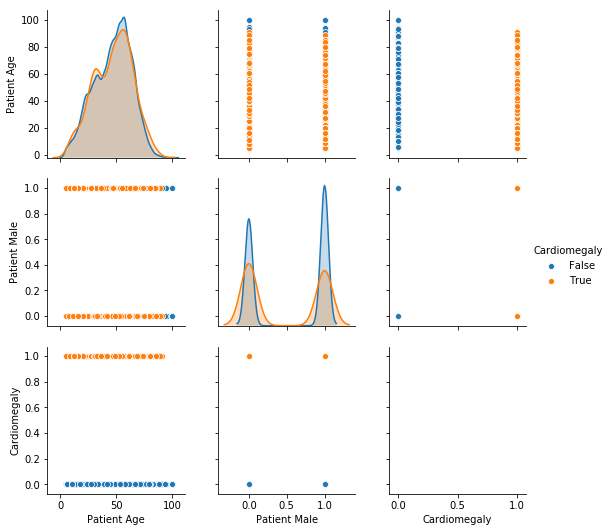

In [3]:
sns.pairplot(all_xray_df[['Patient Age', 'Patient Male', 'Cardiomegaly']], hue='Cardiomegaly')

# Split Data into Training and Validation

False    11104
True      2776
Name: Cardiomegaly, dtype: int64


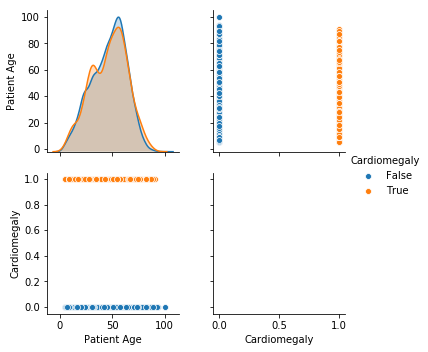

In [4]:
positive_cases = np.sum(all_xray_df['Cardiomegaly']==True)//2
oversample_factor = 4 # maximum number of cases in negative group so it isn't super rare
more_balanced_df = all_xray_df.groupby(['Patient Gender', 'Cardiomegaly']).apply(lambda x: x.sample(min(oversample_factor*positive_cases, x.shape[0]), 
                                                                                   replace = False)
                                                      ).reset_index(drop = True)

print(more_balanced_df['Cardiomegaly'].value_counts())
sns.pairplot(more_balanced_df[['Patient Age', 'Cardiomegaly']], hue='Cardiomegaly')

In [5]:
from sklearn.model_selection import train_test_split
raw_train_df, test_valid_df = train_test_split(more_balanced_df, 
                                   test_size = 0.30, 
                                   random_state = 2018,
                                   stratify = more_balanced_df[['Cardiomegaly', 'Patient Gender']])
valid_df, test_df = train_test_split(test_valid_df, 
                                   test_size = 0.40, 
                                   random_state = 2018,
                                   stratify = test_valid_df[['Cardiomegaly', 'Patient Gender']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
print('train', raw_train_df['Cardiomegaly'].value_counts())
print('test', test_df['Cardiomegaly'].value_counts())
raw_train_df.sample(1)

train 9716 validation 2498 test 1666
train False    7773
True     1943
Name: Cardiomegaly, dtype: int64
test False    1333
True      333
Name: Cardiomegaly, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Cardiomegaly,Patient Male
2902,00013774_035.png,Infiltration,35,13774,77,F,AP,2500,2048,0.168,0.168,NaN,../input/data/images_007/images/00013774_035.png,False,0.0


In [6]:
train_df = raw_train_df.groupby(['Cardiomegaly']).apply(lambda x: x.sample(2000, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

New Data Size: 4000 Old Size: 9716


In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
from PIL import Image
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip=False, 
                              vertical_flip=False, 
                              height_shift_range=0.1, 
                              width_shift_range=0.1, 
                              brightness_range=[0.7, 1.5],
                              rotation_range=3, 
                              shear_range=0.01,
                              fill_mode='nearest',
                              zoom_range=0.125,
                             preprocessing_function=preprocess_input)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [8]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    df_gen = img_data_gen.flow_from_dataframe(in_df,
                                              x_col=path_col,
                                              y_col=y_col,
                                     class_mode = 'raw',
                                    **dflow_args)
    return df_gen

In [9]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'Cardiomegaly', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 8)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'Cardiomegaly', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'Cardiomegaly', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 400)) # one big batch
# used a fixed dataset for final evaluation
final_test_X, final_test_Y = next(flow_from_dataframe(core_idg, 
                               test_df, 
                             path_col = 'path',
                            y_col = 'Cardiomegaly', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 400)) # one big batch

Found 4000 validated image filenames.
Found 2498 validated image filenames.
Found 2498 validated image filenames.
Found 1666 validated image filenames.


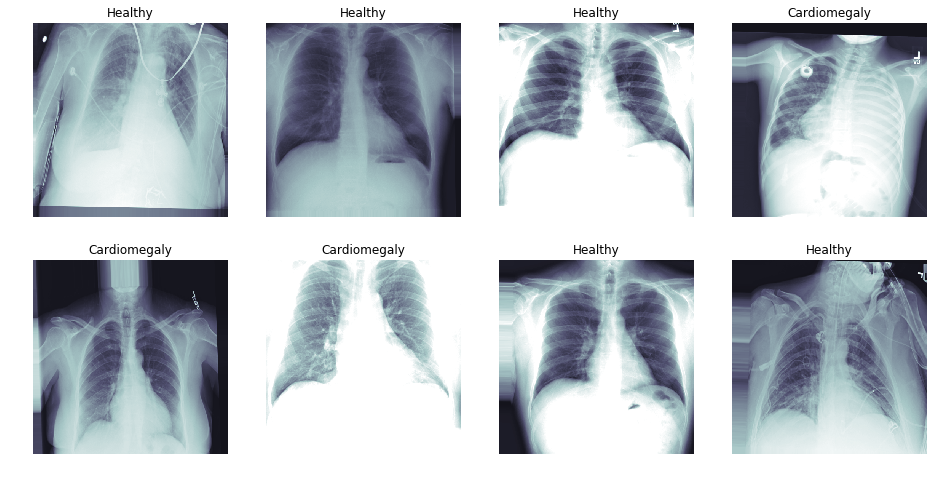

In [10]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -127, vmax = 127)
    c_ax.set_title('%s' % ('Cardiomegaly' if c_y>0.5 else 'Healthy'))
    c_ax.axis('off')

# Pretrained Features


In [ ]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

# Attention Model
It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.


Here we take the output of the pretrained model and apply BatchNormalization

In [12]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
from keras.layers import BatchNormalization
bn_features = BatchNormalization(name='Features_BN')(pt_features)

## Attention
Here we do an attention mechanism to turn pixels in the GAP on an off. It basically outputs a spatial mask of which regions of the pretrained feature map we want to use. It is a very simple 'segmentation' of the feature map without looking into neighborhood.

In [13]:
attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(bn_features)
attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer) # smooth results
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid',
                   name='AttentionMap2D')(attn_layer)

### Rescale Attention
We rescale the feature dimension back out to the original number of features (instead of just 1) by using a hard-coded convolution.

In [14]:
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', name='UpscaleAttention',
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

In [15]:
mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])

## Dropout and Classification


In [16]:
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

attn_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')

attn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])

attn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      (None, 16, 16, 512)  0                                            
__________________________________________________________________________________________________
Features_BN (BatchNormalization (None, 16, 16, 512)  2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  65664       Features_BN[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   4128        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Model Architecture


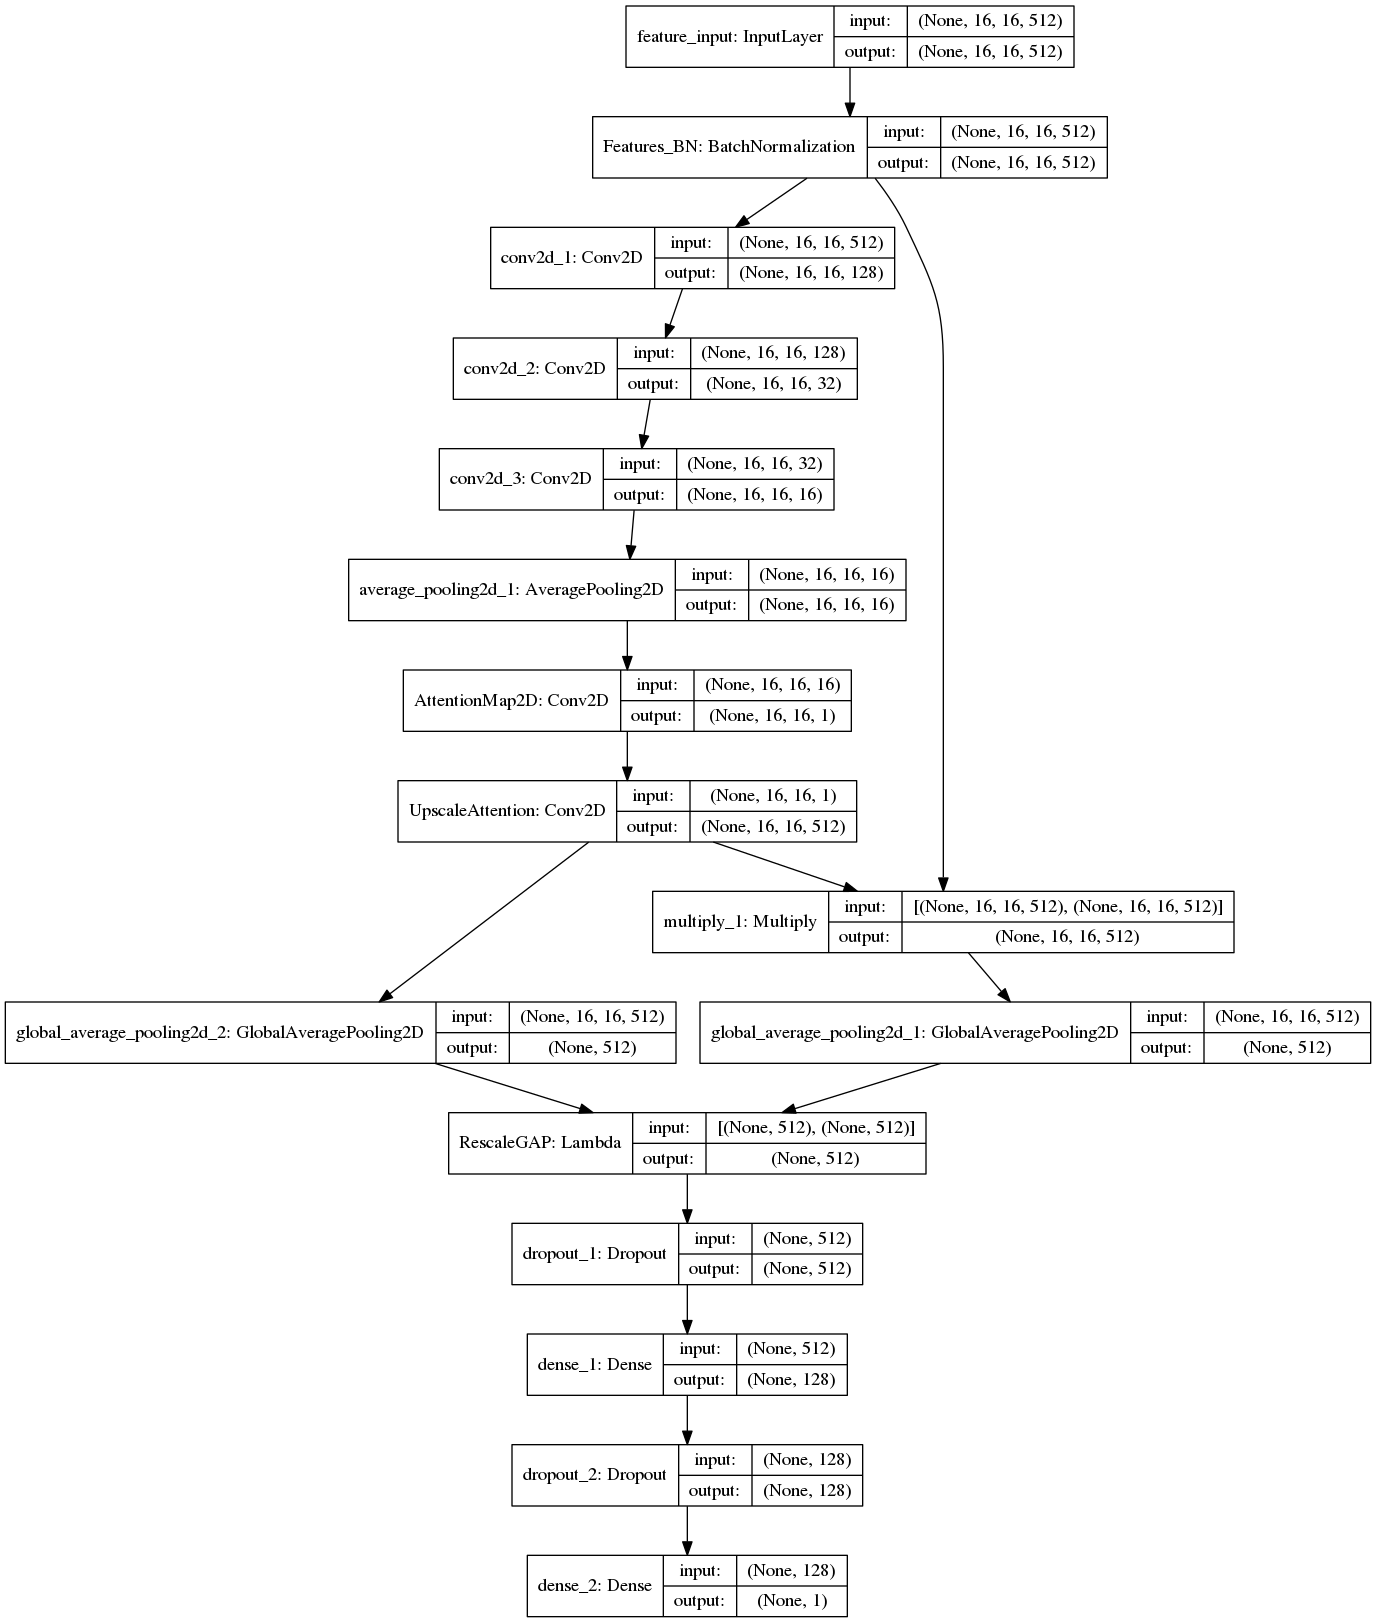

In [17]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(attn_model, show_shapes=True).create_png())

In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cardio_attn')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [19]:
from keras.models import Sequential
from keras.optimizers import Adam
tb_model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
tb_model.add(base_pretrained_model)
tb_model.add(attn_model)
tb_model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])
tb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
attention_model (Model)      (None, 1)                 138690    
Total params: 14,853,378
Trainable params: 137,154
Non-trainable params: 14,716,224
_________________________________________________________________


In [20]:
train_gen.batch_size = 24
tb_model.fit_generator(train_gen, 
                      validation_data = (test_X, test_Y), 
                       steps_per_epoch=train_gen.n//train_gen.batch_size,
                      epochs = 30, 
                      callbacks = callbacks_list,
                      workers = 3)

Epoch 1/30
166/166 [==============================] - 268s 2s/step - loss: 0.6552 - binary_accuracy: 0.6119 - val_loss: 0.5581 - val_binary_accuracy: 0.6975

Epoch 00001: val_loss improved from inf to 0.55814, saving model to cardio_attn_weights.best.hdf5
Epoch 2/30
166/166 [==============================] - 248s 1s/step - loss: 0.6139 - binary_accuracy: 0.6534 - val_loss: 0.6326 - val_binary_accuracy: 0.6125

Epoch 00002: val_loss did not improve from 0.55814
Epoch 3/30
166/166 [==============================] - 245s 1s/step - loss: 0.5918 - binary_accuracy: 0.6750 - val_loss: 0.6553 - val_binary_accuracy: 0.6000

Epoch 00003: val_loss did not improve from 0.55814
Epoch 4/30
166/166 [==============================] - 246s 1s/step - loss: 0.5682 - binary_accuracy: 0.7013 - val_loss: 0.6696 - val_binary_accuracy: 0.5850

Epoch 00004: val_loss did not improve from 0.55814
Epoch 5/30
166/166 [==============================] - 245s 1s/step - loss: 0.5476 - binary_accuracy: 0.7167 - val_los

In [21]:
tb_model.load_weights(weight_path)

# Show Attention
Did our attention model learn anything useful?

In [22]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in attn_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

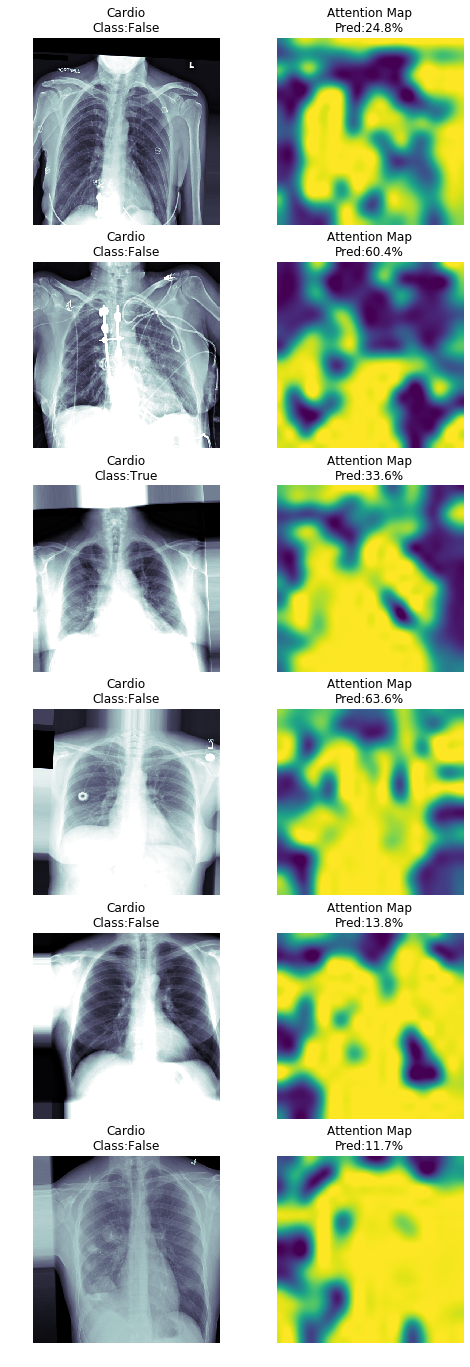

In [23]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [attn_model.get_input_at(0), K.learning_phase()],
           outputs = [attn_layer.get_output_at(0)]
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    cur_features = base_pretrained_model.predict(cur_img)
    attn_img = attn_func([cur_features, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_label = test_Y[c_idx]
    img_ax.set_title('Cardio\nClass:%s' % (real_label))
    pred_confidence = tb_model.predict(cur_img)[0]
    attn_ax.set_title('Attention Map\nPred:%2.1f%%' % (100*pred_confidence[0]))
fig.savefig('attention_map.png', dpi = 300)

In [ ]:
cur_img


In [24]:
pred_Y = tb_model.predict(test_X, 
                          batch_size = 32, 
                          verbose = True)

400/400 [==============================] - 8s 21ms/step


              precision    recall  f1-score   support

     Healthy       0.84      0.78      0.81       325
Cardiomegaly       0.27      0.36      0.31        75

    accuracy                           0.70       400
   macro avg       0.55      0.57      0.56       400
weighted avg       0.73      0.70      0.71       400



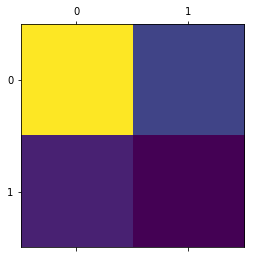

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y, pred_Y>0.5))
print(classification_report(test_Y, pred_Y>0.5, target_names = ['Healthy', 'Cardiomegaly']))

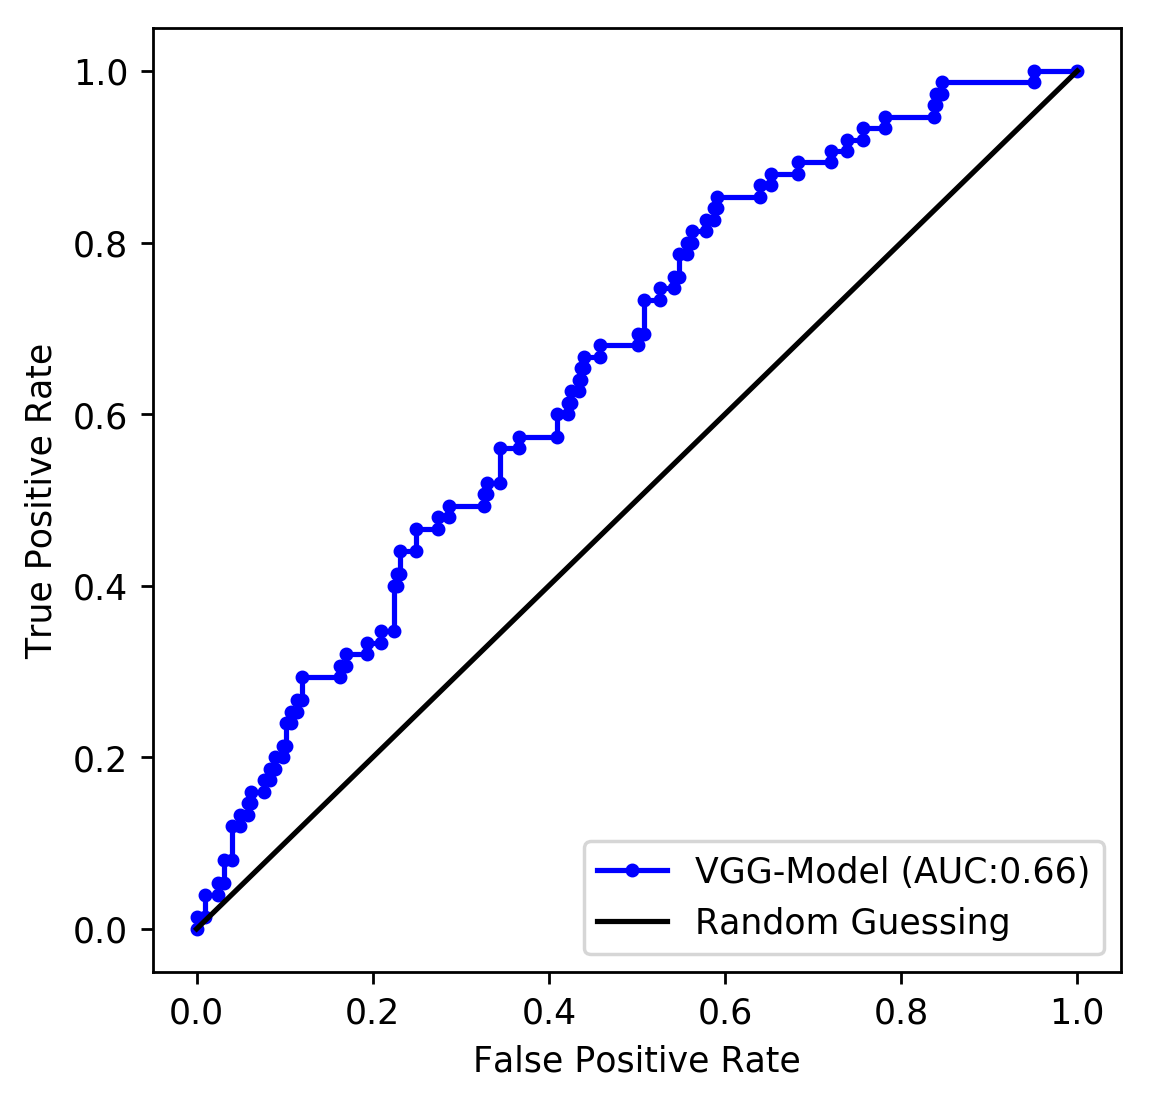

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(test_Y, pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')

# Test Results
The results on the hold-out data which hasn't been touched yet

In [27]:
final_pred_Y = tb_model.predict(final_test_X, 
                                verbose = True, 
                                batch_size = 4)

400/400 [==============================] - 7s 18ms/step


              precision    recall  f1-score   support

     Healthy       0.86      0.81      0.83       322
Cardiomegaly       0.35      0.44      0.39        78

    accuracy                           0.73       400
   macro avg       0.60      0.62      0.61       400
weighted avg       0.76      0.73      0.74       400



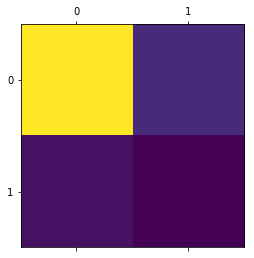

In [28]:
plt.matshow(confusion_matrix(final_test_Y, final_pred_Y>0.5))
print(classification_report(final_test_Y, final_pred_Y>0.5, target_names = ['Healthy', 'Cardiomegaly']))

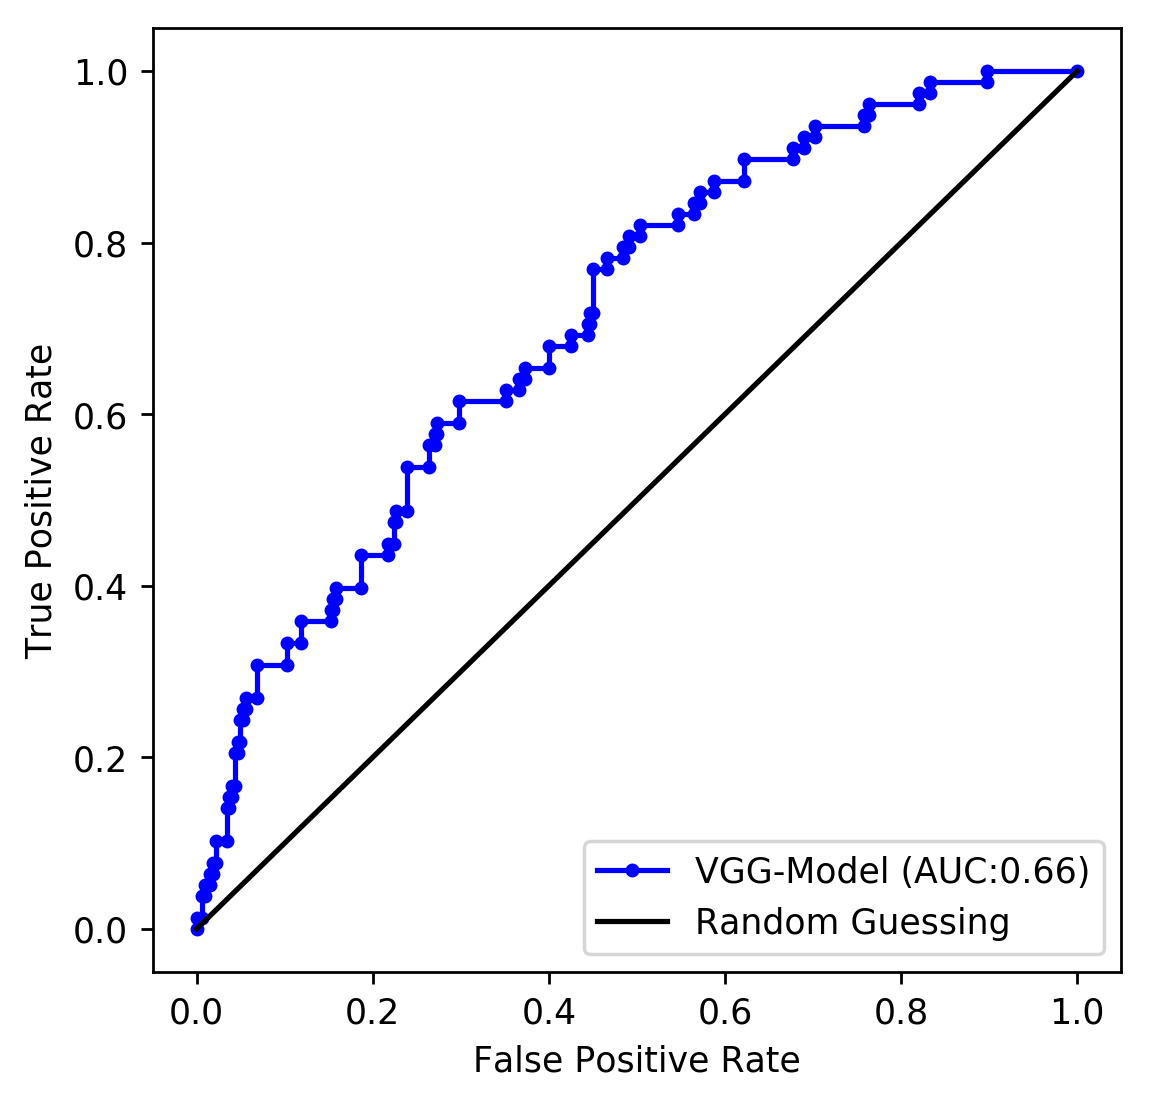

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(final_test_Y, final_pred_Y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, 'b.-', label = 'VGG-Model (AUC:%2.2f)' % roc_auc_score(test_Y, pred_Y))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
fig.savefig('roc.pdf')

In [30]:
tb_model.save('full_pred_model.h5')

# Export the Attention Model
We can run the attention model in addition to the classification to produce attention maps for the image. Here we just package the relevant inputs and outputs together

In [31]:
img_in = Input(t_x.shape[1:])
feat_lay = base_pretrained_model(img_in)
just_attn = Model(inputs = attn_model.get_input_at(0), 
      outputs = [attn_layer.get_output_at(0)], name = 'pure_attention')
attn_img = just_attn(feat_lay)
pure_attn_model = Model(inputs = [img_in], outputs = [attn_img], name = 'just_attention_model')
pure_attn_model.save('pure_attn_model.h5')
pure_attn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
pure_attention (Model)       (None, 16, 16, 1)         72385     
Total params: 14,787,073
Trainable params: 71,361
Non-trainable params: 14,715,712
_________________________________________________________________
